In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import os

import sys
sys.path.insert(0, '../trainingdata')
from datasaver import *
sys.path.insert(0, '../testproblems/darcy')
from darcy_ms import *
sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from NeuralOperator import NeuralOperator
from customlosses import *
from quadrature import *
from customlayers import discretize_functions
from basisfunctions import *

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cuda:3'


sublogdir = 'Fourier'
model = loadmodelfromlabel(model=NeuralOperator, label='L1.2', logdir=logdir, sublogdir=sublogdir, device=device)
# FEM = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_L1', logdir=logdir, sublogdir=sublogdir, device=device)
# FEM.hparams['modeltype'] = 'FEM'
# FEM.hparams['dtype'] = torch.float64
# FEM.hparams['precision'] = 64
# FEM.hparams['Neumannseries'] = False
# projection = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_L1', logdir=logdir, sublogdir=sublogdir, device=device)
# projection.hparams['modeltype'] = 'projection'
# projection.hparams['dtype'] = torch.float64
# projection.hparams['precision'] = 64
values = [1,2,5,10,20,50,100,200]

N_samples = 1
l_min = [0.5,0.5]
l_max = [1,1]

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = UniformQuadrature2D(Q=100)
x = torch.tensor(quadrature.xi_Omega, device=device)
w = quadrature.w_Omega

/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_0 = torch.tensor(A_0, dtype=self.hparams['dtype'], device=self.used_device)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:287: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=self.hparams['dtype'], device=self.used_device)
/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = torch.tensor(f, dtype=self.hparams['dtype'], device=self.used_device)
/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:289: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:285: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F = torch.tensor(self.compute_F(theta, theta_g), dtype=self.hparams['dtype'], device=self.used_device)
/data/storage8/prins/prins/phd/git/ngo-pde-gk/analysisnotebooks/../testproblems/darcy/NeuralOperator.py:286: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(self.compute_d(f, etab, etat, gl, gr), dtype=self.hparams['dtype'], device=self.used_device)


0
0
0
0
0
0
0
0


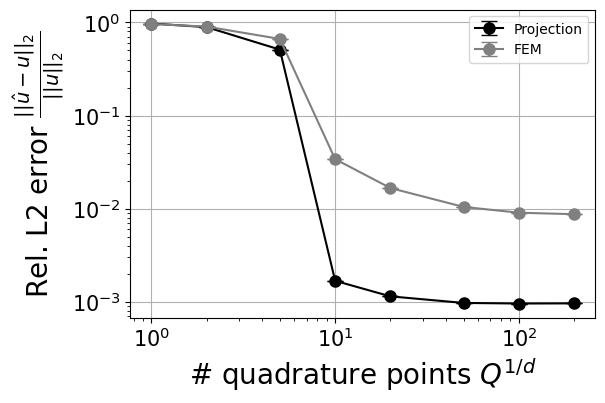

In [6]:
linestyles = ['-','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

dataset = ManufacturedSolutionsSetDarcy(N_samples=N_samples, variables=['x','x'], l_min=l_min, l_max=l_max, device=device)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

L2_scaled_avg = np.zeros((len(values)))
yerr = np.zeros((2,len(values)))
for i in range(len(values)):
    model.hparams['modeltype'] = 'projection'
    model.hparams['n_elements'] = 1
    model.hparams['Q'] = values[i]
    model.hparams['dtype'] = torch.float64
    model.hparams['precision'] = 64
    model.hparams['assembly_mode'] = 'series'
    model.hparams['quadrature'] = 'uniform'
    u_exact = discretize_functions(u, x, dtype=model.hparams['dtype'], device=device).cpu().numpy()
    u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u).detach().cpu().numpy()
    L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
    L2_diff = L22_diff**(1/2)
    L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
    L2_norm = L22_norm**(1/2)
    L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
    L2_scaled_avg[i] = np.average(L2_scaled_array)
    q_l = np.quantile(L2_scaled_array, q_low)
    q_h = np.quantile(L2_scaled_array, q_high)
    yerr[:,i] = np.array([L2_scaled_avg[i] - q_l, -L2_scaled_avg[i] + q_h])

    # plots.append(ax.plot(values, L2_scaled_avg[m], color=colors[m], marker='o', label=labels[m], linestyle='--'))
ax.errorbar(values, L2_scaled_avg, yerr=yerr,  capsize=6, ms=8, label='Projection', color='black', linestyle='-', marker='o')

L2_scaled_avg = np.zeros((len(values)))
yerr = np.zeros((2,len(values)))
for i in range(len(values)):
    model.hparams['modeltype'] = 'FEM'
    model.hparams['n_elements'] = 1
    model.hparams['Neumannseries'] = False
    model.hparams['Q'] = values[i]
    model.hparams['dtype'] = torch.float64
    model.hparams['precision'] = 64
    model.hparams['assembly_mode'] = 'series'
    model.hparams['quadrature'] = 'uniform'
    u_exact = discretize_functions(u, x, dtype=model.hparams['dtype'], device=device).cpu().numpy()
    u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u).detach().cpu().numpy()
    L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
    L2_diff = L22_diff**(1/2)
    L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
    L2_norm = L22_norm**(1/2)
    L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
    L2_scaled_avg[i] = np.average(L2_scaled_array)
    q_l = np.quantile(L2_scaled_array, q_low)
    q_h = np.quantile(L2_scaled_array, q_high)
    yerr[:,i] = np.array([L2_scaled_avg[i] - q_l, -L2_scaled_avg[i] + q_h])

ax.errorbar(values, L2_scaled_avg, yerr=yerr,  capsize=6, ms=8, label='FEM', color='grey', linestyle='-', marker='o')

ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.set_title(r'$0.5<\lambda<1$', fontsize=size_title)
ax.set_xlabel(r'# quadrature points $Q^{1/d}$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-6,1e1)
ax.grid()
plt.legend(fontsize=10)
plt.savefig("Fourier_quadrature12.svg", bbox_inches='tight')#, transparent=True)
plt.show()